# Restaurant Food Cost

### Project Description

Who doesn’t love food? All of us must have craving for at least a few favourite food items, we may also have a few places where we like to get them, a restaurant which serves our favourite food the way we want it to be. But there is one factor that will make us reconsider having our favourite food from our favourite restaurant, the cost. Here in this hackathon, you will be predicting the cost of the food served by the restaurants across different cities in India. You will use your Data Science skills to investigate the factors that really affect the cost, and who knows maybe you will even gain some very interesting insights that might help you choose what to eat and from where.

### You are provided with following 2 files: 

1.     train.csv : Use this dataset to train the model. This file contains all the details related to restaurant food cost as well as the target variable “cost”. You have to train your model using this file.
2.     test.csv : Use the trained model to predict the cost of a two person meal.

# Dataset Attributes

TITLE: The feature of the restaurant which can help identify what and for whom it is suitable for. RESTAURANT_ID: A unique ID for each restaurant. CUISINES: The variety of cuisines that the restaurant offers. TIME: The open hours of the restaurant. CITY: The city in which the restaurant is located. LOCALITY: The locality of the restaurant. RATING: The average rating of the restaurant by customers. VOTES: The overall votes received by the restaurant. COST: The average cost of a two-person meal.

# Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Importing datasets

In [3]:
res_train = pd.read_excel(r"C:\Users\kakug\Downloads\Data_Train.xlsx")
res_test = pd.read_excel(r"C:\Users\kakug\Downloads\Data_Test.xlsx")

# Loading datasets

In [373]:
res_train.head() # Train dataset

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [374]:
res_test.head() # Test dataset

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


# Performing EDA & Dataprepration

In [375]:
res_train.shape # Checking shape of Train dataset

(12690, 9)

In [376]:
res_test.shape # Checking shape of test dataset

(4231, 8)

In [377]:
# Adding a column for dataset identification
res_test['Identify']= 'Test'
res_train['Identify']='Train'

In [378]:
res = pd.concat([res_train,res_test], ignore_index = True) # Concatinating both datasets

<IPython.core.display.Javascript object>

In [379]:
res.head(10) # Checking the final datset 

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,Identify
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200.0,Train
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500.0,Train
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800.0,Train
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800.0,Train
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300.0,Train
5,CASUAL DINING,5618,"North Indian, Chinese, Seafood, Biryani",12noon – 12:30AM (Mon-Sun),Mumbai,Vile Parle West,4.0,550 votes,800.0,Train
6,CAFÉ,4383,"Cafe, Chinese, Pizza, North Indian, Burger","12noon – 11:30pm (Mon, Tue, Thu, Fri, Sat, Sun...",Bangalore,Koramangala 6th Block,4.1,509 votes,600.0,Train
7,MICROBREWERY,1249,Bar Food,1pm – 1am (Mon-Sun),Gurgaon,Sector 29,4.3,1612 votes,1600.0,Train
8,QUICK BITES,7062,"South Indian, North Indian",7am – 10:30pm (Mon-Sun),Bangalore,Bannerghatta Road,3.9,101 votes,300.0,Train
9,QUICK BITES,10109,North Indian,"11am – 2pm, 4pm – 10:30pm (Mon-Sun)",Hyderabad,Dilsukhnagar,3.3,219 votes,200.0,Train


In [380]:
# Lets eliminate white spaces for the ease of processing data
list = ['TITLE','CUISINES','TIME','RATING','Identify', 'CITY','LOCALITY']
for i in list:
    res[i] = res[i].str.replace(' ', '')

TITLE               0
RESTAURANT_ID       0
CUISINES            0
TIME                0
CITY              147
LOCALITY          128
RATING              4
VOTES            1606
COST             4231
Identify            0
dtype: int64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16921 entries, 0 to 16920
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TITLE          16921 non-null  object 
 1   RESTAURANT_ID  16921 non-null  int64  
 2   CUISINES       16921 non-null  object 
 3   TIME           16921 non-null  object 
 4   CITY           16774 non-null  object 
 5   LOCALITY       16793 non-null  object 
 6   RATING         16917 non-null  object 
 7   VOTES          15315 non-null  object 
 8   COST           12690 non-null  float64
 9   Identify       16921 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory us

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

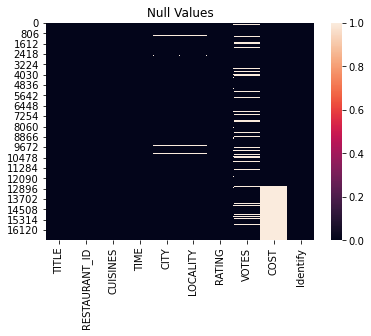

In [381]:
print(res.isnull().sum())
print('X'*80)
print(res.info())
print('X'*80)
sns.heatmap(res.isnull())
plt.title('Null Values')
plt.show()

In [382]:
# Function to analyse columns
def cat_ana(df, x = None):
    series = df[x]
    print(f'Stats summary \n{series.describe()}')
    print('+' *80)
    print(f'Null values \n{series.isnull().sum()}')
    print('+' *80)
    print(f'Series value count is \n{series.value_counts()}')
    print('+' *80)
    print(f'Unique values \n{series.unique()}')

In [383]:
cat_ana(res, x = 'TITLE')

Stats summary 
count          16921
unique           123
top       QUICKBITES
freq            5634
Name: TITLE, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
QUICKBITES                5634
CASUALDINING              4910
None                      1287
CAFÉ                       830
DESSERTPARLOR              508
                          ... 
SWEETSHOP,BEVERAGESHOP       1
CLUB,MICROBREWERY            1
BAKERY,CASUALDINING          1
DESSERTPARLOR,KIOSK          1
BAR,MICROBREWERY             1
Name: TITLE, Length: 123, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Unique values 
['CASUALDINING' 'CASUALDINING,BAR' 'QUICKBITES' 'DESSERTPARLOR' 'CAFÉ'
 'MICROBREWERY' 'QUICKBITES,BEVERAGESHOP' 'CASUALDINING,IRANICAFE'
 'BAKERY,QUICKBITES' 'None' 'BAR,CASUALDINING' 'BAR' 'PUB' '

In [384]:
cat_ana(res, x = 'CUISINES')

Stats summary 
count           16921
unique           5183
top       NorthIndian
freq              716
Name: CUISINES, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
NorthIndian                                               716
NorthIndian,Chinese                                       714
SouthIndian                                               706
FastFood                                                  364
Chinese                                                   226
                                                         ... 
Bakery,Cafe,Pizza,Burger,Sandwich                           1
Arabian,Rolls,FastFood,Biryani,Lebanese                     1
HealthyFood,SouthIndian,FastFood,NorthIndian,Beverages      1
Thai,Asian,Chinese,Italian,Japanese,Malaysian,Momos         1
FastFood,StreetFood,Desserts,Beverages         

In [385]:
res['VOTES'] = res['VOTES'].astype(str)
cat_ana(res, x = 'VOTES')

Stats summary 
count     16921
unique     2076
top         nan
freq       1606
Name: VOTES, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
nan           1606
44 votes        92
22 votes        88
6 votes         87
29 votes        83
              ... 
2585 votes       1
2604 votes       1
1486 votes       1
1810 votes       1
6508 votes       1
Name: VOTES, Length: 2076, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Unique values 
['49 votes' '30 votes' '221 votes' ... '2159 votes' '3807 votes'
 '1913 votes']


In [386]:
cat_ana(res, x = 'TIME')

Stats summary 
count                  16921
unique                  3295
top       11am–11pm(Mon-Sun)
freq                    1862
Name: TIME, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
11am–11pm(Mon-Sun)                             1862
12noon–12midnight(Mon-Sun)                      615
12noon–11pm(Mon-Sun)                            541
11am–12midnight(Mon-Sun)                        419
10am–10pm(Mon-Sun)                              288
                                               ... 
12noon–3:30pm,7pm–2am(Mon),12noon–...             1
11am–11:5pm(Mon),11am–11pm(Tue-Sun)               1
7pm–11pm(Mon-Thu),7pm–11:30pm(Fri-Sun)            1
12noon–3:30pm,6:45pm–11pm(Mon-Sun)                1
9:30am–10pm(Mon),9:30am–12midnight(Tue-Sun)       1
Name: TIME, Length: 3295, dtype: int64
++++++++++++++++++++++++++++++++

In [387]:
res['RATING'] = res['RATING'].astype(str)
cat_ana(res, x = 'RATING')

Stats summary 
count     16921
unique       33
top         3.9
freq       1643
Name: RATING, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
3.9    1643
3.8    1604
4.0    1498
3.7    1437
3.6    1261
4.1    1217
3.5     988
4.2     968
NEW     930
3.4     777
4.3     740
-       672
3.3     485
4.4     484
3.2     349
4.5     274
3.1     263
2.9     242
3.0     229
2.8     191
4.6     184
2.7     129
4.7      90
2.6      85
2.5      51
4.8      49
4.9      28
2.4      24
2.3      15
nan       4
2.2       4
2.1       4
2.0       2
Name: RATING, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Unique values 
['3.6' '4.2' '3.8' '4.1' '4.0' '4.3' '3.9' '3.3' '3.4' '-' '4.5' '3.5'
 '4.4' '2.7' '3.7' '4.7' 'NEW' '3.1' '2.5' '4.6' '2.8' 'nan' '3.0' '3.2'
 '2.6' '2.9' '4.9' '4.8' '2.4'

In [388]:
cat_ana(res, x = 'CITY')

Stats summary 
count       16774
unique        449
top       Chennai
freq         2856
Name: CITY, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
147
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
Chennai                    2856
Bangalore                  2835
Hyderabad                  2458
Mumbai                     2311
NewDelhi                   1754
                           ... 
Gurgoan                       1
Chenna                        1
DLFGalleria                   1
MaladEast                     1
GreaterKailash2NewDelhi       1
Name: CITY, Length: 449, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Unique values 
['Thane' 'Chennai' 'Mumbai' 'Bangalore' 'Gurgaon' 'Hyderabad' 'Kochi'
 'ThaneWest' 'AndheriLokhandwala' 'NewDelhi' 'AndheriWest' 'MaladEast'
 '682036' 'Bangalor' 'NaviMumbai' 'BandraWest' 'Delhi' 'No

In [389]:
cat_ana(res, x = 'LOCALITY')

Stats summary 
count          16793
unique          1629
top       Gachibowli
freq             216
Name: LOCALITY, dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Null values 
128
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series value count is 
Gachibowli                           216
Indiranagar                          187
Kakkanad                             175
Kukatpally                           171
Madhapur                             169
                                    ... 
Nearertofishermenbarandrestaurent      1
Adayar                                 1
OMRPadur                               1
ShankarRoad(NextToBridges)             1
InorbitMallRoadKukatpally              1
Name: LOCALITY, Length: 1629, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Unique values 
['DombivaliEast' 'Ramapuram' 'Saligramam' ... 'OffCarterRoad'
 'SRMBackGate' 'P

In [390]:
# Preparing TITLE
res_title = pd.DataFrame(res['TITLE'].str.split(',').tolist())
res_title.columns = ['T_1',"T_2"]
res_title.replace('None', 'MISSING', inplace = True)
res_title.replace(np.NaN, 'MISSING', inplace = True)
# Preparing the column
res_cuisines = pd.DataFrame(res['CUISINES'].str.split(',').tolist())
res_cuisines. columns = ['C1','C2','C3','C4','C5','C6','C7','C8']
res_cuisines.replace('None', 'MISSING', inplace = True)
res_cuisines.replace(np.NaN, 'MISSING', inplace = True)
res_cuisines.replace('', 'MISSING', inplace = True)
# Preparing Votes column
res_votes = pd.DataFrame(res['VOTES'].str.split(' ').tolist())
res_votes.columns = ['V1','V2']
res_votes.replace('None', 'MISSING', inplace = True)
res_votes.replace(np.NaN, 'MISSING', inplace = True)
res_votes.replace('', 'MISSING', inplace = True)
res_votes.replace('nan', 0, inplace = True)
# Preparing Rating column
res['RATING'].replace('None', np.NaN, inplace = True)
res['RATING'].replace(np.NaN, np.NaN, inplace = True)
res['RATING'].replace('-', np.NaN, inplace = True)
res['RATING'].replace('nan', np.NaN, inplace = True)
# Reorganizing city
res['CITY'] = res['CITY'].astype(str)
res['CITY'].replace(['UttarPradesh','Telangana','TamilNadu','Kerala','Karnataka','Maharashtra','India','nan',
                     'NearRelianceFresh','OuterRingroad'], 'MISSING', inplace = True)
res['CITY'].replace(['IOBBankKamalaNagar','WestMaredpally','Secunderbad','Secunderabad.','Secunderabad.WEHAVENOBRANCHES.',
                     'SecunderabadECIL','SecunderabadmainroadnearsignalNMRECCOLLEGE'],'Secunderabad', inplace = True)
res['CITY'].replace(['Kerala682018','Kerala682028','682036','Vyttila','AluvaCircle','Thykoodam','Thykoodam','Kerala682021',
                     'Kerala682015','Kerala682022',
                     'Kerala682305','Kerala682018' 'Kerala682028','Kerala682024','Kerala682304', 'Kerala682001India',
                     'MGRoadErnakulam','Ernakulam','Kerala682036',682024,'682035.',682036],'Ernakulam', inplace = True)
res['CITY'].replace(['Pallimukku','Elamakkara','PanampillyNagar','Perumbavoor','Palarivattom','p.oKochi','Nedumbassery',
                     'chullickal','KochiPanampillyNagar','aluvacircle','Aluva', 'KochiAluva102', 'FortKochi','Kochi-16',
                     'KochiInternationalAirportVIPRoad' ,'KochiKakkanad','Kochi-18' ,'KochiRavipuram','kochi',
                     'Kerala682013','Kerala683104','Kochi.','KochiChullickal','Kochi-683101' ,'Kaloor','KochiPalarivattom',
                     'KochiVyttila','PonnuruniKochi','KochiElamkulam','ErnakulamCirclekochi'],'Kochi', inplace = True)
res['CITY'].replace(['NoidaExtention','Sector-6Noida201301','NearSector110Noida','GreaterNoida','Sector51Noida'],
                    'Noida', inplace = True)
res['CITY'].replace(['Kukatapally','BKGuda','Champapet','Lingampally','Dilsukhnagar','Kukatpally','Attapur.',
                     'RajivgandhiNagar','Telangana500003','HitechCity','Madhapur','Gandipet','Mehdipatnam' ,'Kondapur',
                     'Telangana500027','Hyderaba','Nizampet',
                     'HyderabadManikonda', 'Manikonda','BegumpetHyderabad','Begumpet','Telangana500081','hyderabad',
                     'JubileeHills','Telengana','BanjaraHills','GachibowliHyderabad','NearSantoshBanjaraHyderabad',
                     'Hyderabad-500032','Telangana500032','Telangana500034','Hyderabad.','HyderabadBehindVacsPastries',
                     'Hyderabadneerusemporium.','Gachibowli','Kothaguda',
                     'TelaganaLandLine:040-48507016'],'Hyderabad', inplace = True)
res['CITY'].replace(['Nungambakkam','AndavarNagar','Kolathur','OMRKarapakkam','Potheri','NallathambiMainRoad','SathyaNagar'
                     ,'Medavakkam','Perungudi','Pallavaram' ,'Velachery','BesantNagar','ChennaiVelachery','chennai',
                     'Chennai-34Landmark-NearLoyolaCollege','AnnaNagarWest','ChennaiMahabalipuram','Mahabalipuram' ,
                     'ChennaiOpposite5CBusstand' ,'ChennaiPadur','Chennai40','ChennaiInjambakkam', 
                     'BalavinayagarNagarChennai','T-NagarChennai','Chennai-600018','chennai-119',
                     'Chenna','ChennaiKovalam','Chennaiopp:Vasanth&co',
                     'Mogappair.Chennai', 'ChennaiPerungudi', 'ChennaiThuraipakkam', 'ChennaiThousandLights',
                     'Chennai-600107','ECRNEELANKARAIChennai600115', 'Chennai.', 'Chennai(BangOppositeIndianBank)',
                     'Chennai-40', 'ChennaiChrompet','Chennai.(NearHotelMatshya)','AnnaNagarEast' ,
                     'Sholinganallur.Chennai','Chennai(AboveBombayBrasserie)' ,'Chennai37','Chennai600040',
                     'Chennai-600008','Chennai-600040','Chennai600034.','Arumbakkamchennai-600106.','DewanRamaRoad',
                     'Semmancheri','ChennaiTeynampet'],'Chennai', inplace = True)
res['CITY'].replace(['GurgaonHaryana','NewDelhi110011','Gurugram','RodeoDriveSector49',
                     'PVRplazacinemabuildingConnaughtPlace','NewDelhi110075',
                     'Amritkaurmarketoppositenewdelhirailwaystationpaharganj','Gurgoan','Faridabd','DLFGalleria',
                     'Kalkaji','Delh.','NewDelhi110011''GurgaonHaryana','Janakpuri','Dist.CenterNewDelhi' ,
                     'IndiaGateNewDelhi','Girgaum',
                     'GreaterKailash1(GK1)NewDelhi','Haryana','Gurgaon','VaishaliGhaziabad','Sector7Dwarka',
                     'GurgaonHaryanaIndia','NewDelhi..NearbySBIbank','NearRamlilaGround','OldDelhi',
                     '6&7-4/64SubhashNagar','AshokViharPhase1','Saket','Pitampura','ChanderNagarNewDelhi',
                     'NewDelhi.','NewDelhi-110024','GreaterKailash2NewDelhi','Delhi110085',
                     'KarolBagh','Rohini','DelhiNCR','Dwarka','oppgurudwaraShakurpur','Delhi'],'NewDelhi', inplace = True)
res['CITY'].replace(['B.B.M.PEast(Karnataka)-560049','Karnataka560037','Karnataka560043' ,'Karnataka560102','SGPalya',
                     'ThammenahalliVillage','Karnataka560103','HBRLayout',
                     'Sarjapur','BTMLayout','VijayaNagar','RajarajeshwariNagarbangalore','JPNagar', 'Marathahalli' ,
                     'KanakapuraRoadBanglore','Banglaore','Bangalorelandmarkabovemahaveerhardware','Phase1Bangalore',
                     'Bangalore560076',
                     'MalleshwaramBangalore', 'BangaloreRoad', 'KadubesanahalliBangalore','Whitefield','Bangalore-560095',
                     'Bangalore-560103','BrigadeRoad','HSRLayout' ,'OffBrigadeRoad','Banaswadi(NexttoIndianBank)Bangalore',
                     'BTMBangalore','BangaloreKoramangala7thBlock','bangalore:560085',
                     'CPRlayoutharlurmainroadoppositetoozoneevergreenapartmentBangalore-','HosurRoad','Bangalore.',
                     'Bangalore-560076', 'JPNagarBangalore','WhitefieldBangalore','Banglore',
                     'Bengaluru','Bengalore','5thMainTeachersColonyKoramangalaBlock1Bangalore560034', 'Bangalor',
                     'Bangalore-560066'],'Bangalore', inplace = True)
res['CITY'].replace(['Maharashtra400102','Maharashtra400092','Maharashtra400092','NaviMumbai.','MumbaiMahim','DombivaliEast'
                     ,'Kandivali','Thane','oppmukteshwarashrampowai','Rajanpada','PokhranRoad2','MulundWest','Chowpatty',
                     'VirarMumbai','ChurchStreet','MumbaiVeeraDesaiArea','MumbaiUlhasnagar',
                     'JogeshwariWestMumbai','Miraraodeast','MumbaiChakala','BorivaliWest','Mumbai400070','KandivaliWest',
                     'Thane(W)','ThaneWest','ThaneWestThaneWest''NearAndheriWestStation','ThaneMumbai',
                     'Jogeshwari(w)Mumbai','MumbaiChakala','BorivaliWest','BorivaliEast.' ,'WestMumbai','navimumbai',
                     'VasaiWest.','Mahim','GrantRoadWest','Mumbai-400007','NayaNagarMiraRoad','LowerParel','Mumbai.',
                     'MumbaiAndheriEast', 'VirarWest','MarineDrive','Bhayandar''Khar(west)','kharwest',
                     'MumbaiDombivaliEast','Powai','KalyanWest','GrantRoadWest','Mumbai-400007','NayaNagarMiraRoad',
                     'LowerParel','Mumbai.','MumbaiAndheriEast', 
                     'VirarWest','MarineDrive','Bhayandar','Khar(west)','kharwest','MumbaiDombivaliEast','Powai',
                     'Mumbai-400013','AndheriwestMumbai','BandraW','Mumbai-80','AndheriLokhandwala.','EastMumbai',
                     'Kalyan','BadlapurWest.','LowerParelWest','Navi-Mumbai' ,'Mulundwest',
                     'MumbaiThisisaDelivery&Take-awayRestaurantonly.','Vasaiwest','BorivaliWest.''GolfCourseRoad',
                     'KharMumbai','VasaiMumbai','NearAndheriEastStation', 'MiraRoadThaneMumbai',
                     'Kurla(W)','Mumbai400015','Dombivli', 'MohammadAliRoadMumbai','KurlaMumbai','MumbaiMumbra',
                     'Miumbai','Borivali(W)Mumbai:400092.' 'DombivaliEast','Kandivali''MumbaiMahim',
                     'Powai(NexttoPowaiPlaza)','MulundEast','GoregaonWest','Chembur.','AndheriLokhandwala',
                     'AndheriWest','MaladEast','BandraWest','Borivali(W)Mumbai:400092.'],'Mumbai', inplace = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [391]:
# combining all dataframes:
res_total = pd.concat([res,res_title,res_cuisines,res_votes], axis =1)
# Droping duplicated information
res_total.drop(['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME','VOTES','V2','LOCALITY'],axis = 1, inplace =True)

<IPython.core.display.Javascript object>

In [392]:
# Filling null values in rating with title wide mean assuming new restaurants would try to compete with restaurants of 
# similar types
res_total['RATING'] = (res_total.groupby('T_1')).transform(lambda x: x.fillna(x.mean()))

In [393]:
# Encoding the required Data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
val = ['CITY', 'RATING','T_1', 'T_2', 'C1', 'C2', 'C3','C4', 'C5', 'C6', 'C7', 'C8', 'V1']
for i in val:
    res_total[i] = le.fit_transform(res_total[i].astype(str))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

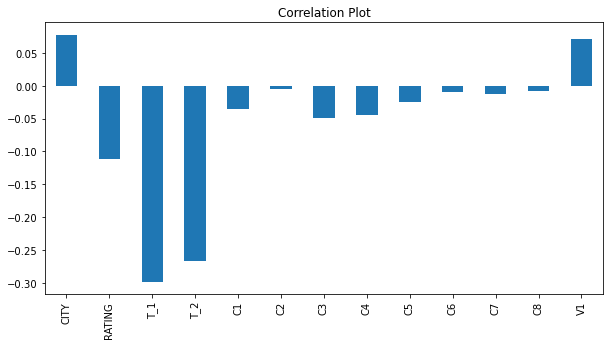

In [394]:
# Checking Coorelation
res_total.drop(['COST'],axis=1).corrwith(res_total['COST']).plot(kind ='bar', figsize =(10,5))
plt.title('Correlation Plot')
plt.show()

# Building Model

In [395]:
#Importing required libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

In [396]:
# Segrigating data into x & y
train = res_total.loc[res_total['Identify']== 'Train']
test = res_total.loc[res_total['Identify']== 'Test']
x = (train.drop(['COST','Identify'], axis = 1))
y = train['COST']
testy = (test.drop(['COST','Identify'], axis = 1))

In [397]:
# identifying best random state
best_random_state = 0
accu = 0
for i in range(30,100):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.22, random_state = i)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    predlr = lr.predict(x_test)
    r2s = r2_score(y_test,predlr)
    if r2s > accu:
        accu = r2s
        best_random_state = i
        
        
print(f'The best random state is {best_random_state} with accuracy is {accu *100}%')

The best random state is 67 with accuracy is 19.26617346066629%


In [398]:
#Identifying best Algorithm
import warnings
warnings.filterwarnings('ignore')
models=[LinearRegression(),Lasso(alpha =0.001),Ridge(alpha =0.001), 
      ElasticNet(alpha =0.001), RandomForestRegressor(),
      AdaBoostRegressor(), DecisionTreeRegressor(), XGBRegressor(), GradientBoostingRegressor()]
for m in models:
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.22, random_state = 67)
    m.fit(x_train,y_train)
    pred = m.predict(x_test)
    cv_score = cross_val_score(m,x,y,cv= 10).mean()
    print(f'For algorithm {m} R2 Score is {r2_score(y_test,pred)*100}')
    print(f'For algorithm {m} mean Sqr Error is {mean_squared_error(y_test,pred)*100}')
    print(f'For algorithm {m} mean abs. error is {mean_absolute_error(y_test,pred)*100}')
    print(f'For algorithm {m} cross validation score is {cv_score*100}')
    print(f'Difference between r2 score & cv score = {(r2_score(y_test,pred)*100)-(cv_score*100)}\n')
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

For algorithm LinearRegression() R2 Score is 19.26617346066629
For algorithm LinearRegression() mean Sqr Error is 28621515.93458642
For algorithm LinearRegression() mean abs. error is 32393.692945094874
For algorithm LinearRegression() cross validation score is 15.76493725210588
Difference between r2 score & cv score = 3.5012362085604103

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For algorithm Lasso(alpha=0.001) R2 Score is 19.26617212087901
For algorithm Lasso(alpha=0.001) mean Sqr Error is 28621516.40956382
For algorithm Lasso(alpha=0.001) mean abs. error is 32393.6935616879
For algorithm Lasso(alpha=0.001) cross validation score is 15.764946815889624
Difference between r2 score & cv score = 3.5012253049893847

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For algorithm Ridge(alpha=0.001) R2 Score is 19.266173453860702
For algorithm Ridge(alpha=0.001) mean Sqr Error is 28621515.9369991

In [399]:
from sklearn.model_selection import GridSearchCV
parameters = {'booster':['gbtree', 'gblinear', 'gbtree']}
clf = GridSearchCV(XGBRegressor(),parameters)
clf.fit(x_train,y_train)
clf.best_params_

{'booster': 'gbtree'}

In [400]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.22, random_state = 67)
xgbr = XGBRegressor(booster= 'gbtree')
xgbr.fit(x_train,y_train)
pred = xgbr.predict(x_test)
cv_score = cross_val_score(xgbr,x,y,cv= 10).mean()
print(f'For algorithm {m} R2 Score is {r2_score(y_test,pred)*100}')
print(f'For algorithm {m} mean Sqr Error is {mean_squared_error(y_test,pred)*100}')
print(f'For algorithm {m} mean abs. error is {mean_absolute_error(y_test,pred)*100}')
print(f'For algorithm {m} cross validation score is {cv_score*100}')
print(f'Difference between r2 score & cv score = {(r2_score(y_test,pred)*100)-(cv_score*100)}\n')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

For algorithm GradientBoostingRegressor() R2 Score is 94.64664244486212
For algorithm GradientBoostingRegressor() mean Sqr Error is 1897856.3897657902
For algorithm GradientBoostingRegressor() mean abs. error is 2377.762591206925
For algorithm GradientBoostingRegressor() cross validation score is 90.03959159446853
Difference between r2 score & cv score = 4.607050850393591

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [403]:
predt = xgbr.predict(x)
print(f'R2 Score is {r2_score(y,predt)*100}')
print(f'Mean Sqr Error is {mean_squared_error(y,predt)*100}')
print(f'Mean abs. error is {mean_absolute_error(y,predt)*100}')

R2 Score is 98.86743381791966
Mean Sqr Error is 445214.5510534753
Mean abs. error is 1089.5951922058214


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

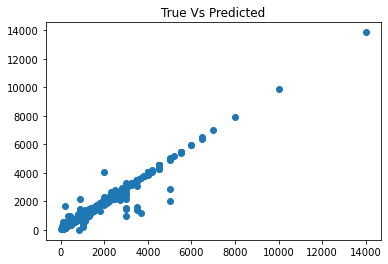

In [404]:
plt.scatter(y,predt)
plt.title('True Vs Predicted')
plt.show()

# Saving the Model

In [405]:
import joblib
joblib.dump(xgbr,'Restaurant_cost_pred.obj')

['Restaurant_cost_pred.obj']